<div style='text-align: center;'>
<img src="../images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lab Class - Week 10

## Department of Mathematics

Last time we demonstrated the Crank-Nicolson finite difference method applied to European options
- We showed how accurate it can be,
- How to apply it different problems,
- This time we cover how to adapt finite difference methods to early exercise options.

## American Options


A reminder that American option allow for early exercise, and we must allow the holder of the option to make the optimal decision to exercise early, but without perfect foresight (only using information up to and including the current time $t$). 

Consider the case of an American put option writing on a standard asset $S$ trading in the market. According to standard theory, we can find the solution to the problem by solving 
$$
\frac{\partial P}{\partial t} + \frac12\sigma^2S^2\frac{\partial^2 P}{\partial S^2} + rS\frac{\partial P}{\partial S} - rP \leq 0
\tag{10.1}
$$
$$
P(S,t) \geq X-S
\tag{10.2}
$$
with
$$
P(S,T) = \max(X-S,0),
\tag{10.3}
$$
and the optimal solution will satisfy either the equaility in (10.1) or (10.2), whichever gives the larger result.

Now when using the explicit finite difference method, we have the equation for the value of $P_j^i$ at a grid point
$$
P_j^i = \frac{1}{1+r\Delta t}(AP_{j+1}^{i+1} + BP_{j}^{i+1}+ CP_{j-1}^{i+1})
$$
which satisifies the equality of (10.1). So to get the optimal solution for an American put option, we simple choose the maximum between (10.1) and (10.2), or
$$
P_j^i = \max\left[\frac{1}{1+r\Delta t}(AP_{j+1}^{i+1} + BP_{j}^{i+1}+ CP_{j-1}^{i+1})~ ,~ X - S_j \right] .
$$


In [1]:
# To get started import some libraries
import numpy
import scipy
import matplotlib.pyplot as plt

Coding this is up is pretty easy, we just add the maximum condition on one line of code to get the American put option value!

In [2]:
def finiteDiff_AmericanPut( X,T, r,sigma, SU,imax,jmax):
    ## calculate the step size and then setup storage for the value
    dS = float(SU) / int(jmax)
    dt = float(T) / int(imax)

    S = numpy.zeros(int(jmax)+1)
    t = numpy.zeros(int(imax)+1)
    vNew = numpy.zeros(int(jmax)+1)
    vOld = numpy.zeros(int(jmax)+1)

    # calculate the values of S_j and t^i and check they work as expected
    for j in range(jmax+1):
        S[j] = j*dS

    for i in range(imax+1):
        t[i] = i*dt
        
    # first enter the value of the option at expiry
    for j in range(jmax+1):
        vOld[j] = max( X - S[j] , 0.)
        vNew[j] = max( X - S[j] , 0.)
        
    # next loop back through time
    for i in range(imax-1,-1,-1):
        # apply boundary condition at S=0
        vNew[0] = X
        for j in range(1,jmax):
            # input explicit finite difference formula
            A = 0.5*sigma*sigma*j*j*dt + 0.5*r*j*dt
            B = 1.0 - sigma*sigma*j*j*dt
            C = 0.5*sigma*sigma*j*j*dt - 0.5*r*j*dt
            # use vNew[j] for V_j^i and vOld[j] for V_j^{i+1}
            vNew[j] =max ((A*vOld[j+1] + B*vOld[j] + C*vOld[j-1]) / ( 1 + r*dt) ,X - S[j] )
            
        # apply boundary condition at S=S_U
        vNew[jmax] = 0.0
        
        # set old values equal to new ones
        # MAKE SURE THIS IS A DEEP COPY!
        vOld = numpy.copy(vNew)
    
    return S,vNew

In [3]:
def finiteDiff_EuroPut( X,T, r,sigma, SU,imax,jmax):
    ## calculate the step size and then setup storage for the value
    dS = SU / jmax
    dt = T / imax

    S = numpy.zeros(jmax+1)
    t = numpy.zeros(imax+1)
    vNew = numpy.zeros(jmax+1)
    vOld = numpy.zeros(jmax+1)

    # calculate the values of S_j and t^i and check they work as expected
    for j in range(jmax+1):
        S[j] = j*dS

    for i in range(imax+1):
        t[i] = i*dt
        
    # first enter the value of the option at expiry
    for j in range(jmax+1):
        vOld[j] = max( X - S[j] , 0.)
        vNew[j] = max( X - S[j] , 0.)
        
    # next loop back through time
    for i in range(imax-1,-1,-1):
        # apply boundary condition at S=0
        vNew[0] = X*numpy.exp(-r*(T-i*dt))
        for j in range(1,jmax):
            # input explicit finite difference formula
            A = 0.5*sigma*sigma*j*j*dt + 0.5*r*j*dt
            B = 1.0 - sigma*sigma*j*j*dt
            C = 0.5*sigma*sigma*j*j*dt - 0.5*r*j*dt
            # use vNew[j] for V_j^i and vOld[j] for V_j^{i+1}
            vNew[j] =  (A*vOld[j+1] + B*vOld[j] + C*vOld[j-1]) / ( 1 + r*dt) 
            # apply boundary condition at S=S_U
        vNew[jmax] = 0.0
        
        # set old values equal to new ones
        # MAKE SURE THIS IS A DEEP COPY!
        vOld = numpy.copy(vNew)
    
    return S,vNew

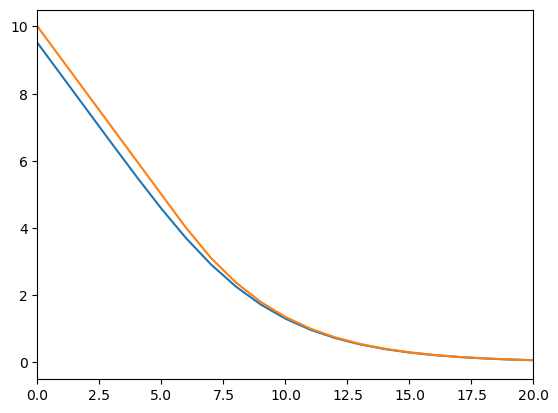

In [4]:
S,vAmerican = finiteDiff_AmericanPut(10,1,0.05 , 0.4,50,1000,50)
S,vEuro = finiteDiff_EuroPut(10,1,0.05 , 0.4,50,1000,50)

# check a plot to see what it looks like
plt.xlim(0,20)
plt.plot(S,vEuro)
plt.plot(S,vAmerican)

On the output, we should be able to see the resulting solution satisfies $P\geq X-S$. 

# Tasks

- Consider the parameters $X=10$, $T=1$, $r=0.05$ and $\sigma=0.4$.
- Run the American option for different value of $imax$ and $jmax$, is this method stable for all values of $imax$?
- Using the calculated value at $S_0=X$, a sufficiently large $S^U$, and a stable value of $imax$, verify that the convergence rate is $O((\Delta S)^2)$.
- Use interpolation to get the value of the option with $S_0=9.735$, is the convergence rate still $O((\Delta S)^2)$?
- Check that the converged value matches with the result on my website:

[American Option Solver](https://personalpages.manchester.ac.uk/staff/paul.johnson-2/pages/americanCalculator.html)

In [5]:
X=10
T=1
r=0.05
sigma=0.4

We have a choice to make around $S^U$, $imax$ and $jmax$. We know that numerical
solution converges to real solution as those three values tend to infinity.
We want to produce some tables to show this is the case.

To produce tables, we will need to pick a single point in the state space
to see what happens at that point. Choose $S_0=X$ and get results for
$V(S_0,t=0)$.

In [6]:
S,vAmerican = finiteDiff_AmericanPut(X,T, r ,sigma,5*X,1000,50)
 
print( "V(S_0=X,t=0)=", numpy.interp( X , S , vAmerican ) )

V(S_0=X,t=0)= 1.3535060555529692


Use numba to speed up these calculations...

In [7]:
import numba

finiteDiff_AmericanPut_njit = numba.njit(finiteDiff_AmericanPut)

Now try varying imax and jmax in different tables.

In [8]:
# Fix S^U=50, jmax=100 and vary imax

SU = 50
jmax = 100

valueOld = 1.
diffOld = 1.

for k in range(0,14):
    imax = 10* 2**k
    S,vAmerican = finiteDiff_AmericanPut_njit(X,T, r , sigma,SU,imax,jmax)
    value =  numpy.interp( X , S , vAmerican )
    diff = value - valueOld
    print( imax , value , diffOld/diff )
    diffOld = diff
    valueOld = value

10 0.0 -1.0
20 0.0 -inf
40 0.0 nan
80 1.0946165432300548e+19 0.0
160 4.0407918830793335e+41 2.708915912778684e-23
320 2.5546425526895203e+95 1.5817445297093322e-54
640 5.460300388599964e+117 4.6785751165322567e-23
1280 23.799536462538747 -1.0
2560 1.3634227535469323 2.4337104274933392e+116
5120 1.363371859465922 440839.35231064534
10240 1.363346428144493 2.001236198124707
20480 1.363333724545926 2.001899012734321
40960 1.3633273792771363 2.002058382053706
81920 1.3633242068913263 2.0001567178989443


/var/folders/v8/wf2x6lgh8xj5nh006s7bngz80000gs/T/ipykernel_69056/50814272.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  print( imax , value , diffOld/diff )
/var/folders/v8/wf2x6lgh8xj5nh006s7bngz80000gs/T/ipykernel_69056/50814272.py:14: RuntimeWarning: invalid value encountered in scalar divide
  print( imax , value , diffOld/diff )


With imax varying by 2 each time, if the method is order one, i.e.
$$
V_\text{approx} = V* + \frac{A}{imax} + ...
$$
then successive difference should converge towards a value of 2.

Now try varying jmax...

In [9]:
# Fix S^U=50, imax=100000 and vary jmax
SU = 5*X
imax = 100000

valueOld = 1.
diffOld = 1.

for k in range(0,5):
    jmax = 10* 2**k
    S,vAmerican = finiteDiff_AmericanPut_njit(X,T, r , sigma,SU,imax,jmax)
    value =  numpy.interp( X , S , vAmerican )
    diff = value - valueOld
    print( imax ,jmax, value , diffOld/diff )
    diffOld = diff
    valueOld = value
    

100000 10 1.003281272012926 304.75986021904265
100000 20 1.2783319270327689 0.011929700777078068
100000 40 1.346699472729239 4.023117287857302
100000 80 1.3615182371978158 4.613579346742647
100000 160 1.3654104458559317 3.8072893234223946


With `jmax` increasing by 2 each time, if the method is order two, i.e.
$$
V_\text{approx} = V^\star + \frac{B}{jmax^2} + ...
$$
then successive difference should converge towards a value of 4. It looks
as though it does although stability might be an issue.

We can vary both at the same time, and if we choose 
$$
imax = \sigma^2 T jmax^2
$$
to maintain stability, then
$$
V_\text{approx} = V^\star + \frac{A}{imax} + \frac{B}{jmax^2} + ....
$$
or
$$
V_\text{approx} = V^\star + \frac{A'}{jmax^2} + ....
$$


In [10]:
# Fix S^U=50 vary imax and jmax

SU = 50
valueOld = 1.
diffOld = 1.

for k in range(0,7):
    jmax = 10* 2**k
    imax = int(sigma*sigma*T*jmax*jmax)
    S,vAmerican = finiteDiff_AmericanPut_njit(X,T, r , sigma,SU,imax,jmax)
    value =  numpy.interp( X , S , vAmerican )
    diff = value - valueOld
    print( imax,jmax , value , (4.*value - valueOld) /3. )
    diffOld = diff
    valueOld = value
    

16 10 1.0132011175924525 1.01760149012327
64 20 1.2822572021163605 1.3719425636243299
256 40 1.3476288865134731 1.3694194479791773
1024 80 1.3617662164254245 1.3664786597294085
4096 160 1.365474020668096 1.3667099554156532
16384 320 1.3664373749996455 1.3667584931101622
65536 640 1.3666800553368592 1.3667609487825974


Now writing
$$
V_\text{approx} = V^\star + \frac{A'}{jmax^2} + ....
$$
we can find $V^\star$ using extrapolation
$$
V^\star = \frac13( 4 * V_{2jmax} - V_\text{jmax} )
$$
All that is left now is grid truncation errors
$$
V^\star = V_\text{exact} + \epsilon(S^U) + ....
$$
for some unknown function $\epsilon$. We would like to choose $S^U$ large
enough such that the error function $\epsilon < tol$ where $tol$ is required accuracy.


In [11]:
# Fix S^U=100 vary imax and jmax

SU = 100
valueOld = 1.
diffOld = 1.

for k in range(0,8):
    jmax = 10* 2**k
    imax = int(sigma*sigma*T*jmax*jmax)
    S,vAmerican = finiteDiff_AmericanPut_njit(X,T, r , sigma,SU,imax,jmax)
    value =  numpy.interp( X , S , vAmerican )
    diff = value - valueOld
    print( imax,jmax , value , (4.*value - valueOld) /3. )
    diffOld = diff
    valueOld = value


16 10 0.4993347979074258 0.33244639720990105
64 20 1.0057224138739593 1.1745182858628038
256 40 1.2793096714627807 1.3705054239923877
1024 80 1.3469291743920235 1.3694690087017711
4096 160 1.3615780995304456 1.3664610745765862
16384 320 1.3654242894035356 1.3667063526945655
65536 640 1.366424313580752 1.3667576549731573
262144 1280 1.3666766897890816 1.3667608151918582


In [12]:
# Fix S^U=200 vary imax and jmax

SU = 200
valueOld = 1.
diffOld = 1.

for k in range(0,9):
    jmax = 10* 2**k
    imax = int(sigma*sigma*T*jmax*jmax)
    S,vAmerican = finiteDiff_AmericanPut_njit(X,T, r , sigma,SU,imax,jmax)
    value =  numpy.interp( X , S , vAmerican )
    diff = value - valueOld
    print( imax,jmax , value , (4.*value - valueOld) /3. )
    diffOld = diff
    valueOld = value


16 10 5.249667398953713 6.666223198604951
64 20 0.49839926378879157 -1.0853567812661824
256 40 1.0038880902261396 1.1723843657052555
1024 80 1.278574439044774 1.370136555317652
4096 160 1.3467550636472196 1.3694819385147017
16384 320 1.3615312730966418 1.3664566762464492
65536 640 1.365411870758711 1.3667054033127342
262144 1280 1.366421068095099 1.3667574672072282
1048576 2560 1.366675852394478 1.366760780494271


In these cases, all three values seem to be converging to the same result, so choosing
the smallest one (with smallest value of $\Delta S$) is best. If you choose $S^U$ **too**
small it will eventually have an effect.\ Say $S^U=20$, we get

In [13]:
# Fix S^U=20 vary imax and jmax

SU = 20
valueOld = 1.
diffOld = 1.

for k in range(0,6):
    jmax = 10* 2**k
    imax = int(sigma*sigma*T*jmax*jmax)
    S,vAmerican = finiteDiff_AmericanPut_njit(X,T, r , sigma,SU,imax,jmax)
    value =  numpy.interp( X , S , vAmerican )
    diff = value - valueOld
    print( imax,jmax , value , (4.*value - valueOld) /3. )
    diffOld = diff
    valueOld = value


16 10 1.3292542060817054 1.4390056081089406
64 20 1.3569553312615548 1.366189039654838
256 40 1.3641355110594868 1.3665289043254643
1024 80 1.3659269713404394 1.3665241247674238
4096 160 1.3663717613075987 1.3665200246299853
16384 320 1.3664824550291204 1.3665193529362945


Result is only 4 digits of accuracy (1.367), if that is all that is required it's
ok, otherwise choose $S^U$ larger.


# Penalty Method


Here we aim to solve the classic American put option problem using the so called penalty method. 
The penalty method works by solving a slightly different problem, which can be shown to converge to the true solution. The alternative problem we solve combines the inequalities in (10.1) and (10.2) to give
$$
\frac{\partial P}{\partial t} + \frac12\sigma^2S^2\frac{\partial^2 P}{\partial S^2} + rS\frac{\partial P}{\partial S} - rP + \rho\max((X - S) - P , 0 ) = 0
\tag{10.4}
$$
so that in the limit as $\rho \rightarrow \infty$, the value function $P$ satisfies
$$
P(S,t) \geq X-S.
$$
Note that (10.4) is no longer an inequality, so it can be solved directly using a matrix solver. 

However, given a Crank-Nicolson scheme, we won't know if the term $\rho\max((X - S) - P , 0 )$ is zero or has some value until we have solved to find $P$, so some iteration is required. Luckily the number of iterations required to reach a full solution tends to be very small (typically of the order 10 or less).

The method as written here looks confusing, but once written in code it is relatively trivial to adapt to new problems. 
The algorithm works as follows:
- Write down a standard finite difference scheme for the original PDE (including the boundary conditions)
- Take a guess at the solution $v_j^{i,q}$ at the current time step, where $v_j^{i,q}$ is the $q$th guess.
- If $v_j^{i,q} < X - S_j$ adjust the original finite difference approximation to
$$
\hat b_j = b_j - \rho
$$
$$
\hat d_j = d_j - \rho ( X - S_j )
$$ 
- Solve new system with a Thomas algorithm to find $v_j^{i,q+1}$.
- Check for convergence in $||\boldsymbol{v}^{i,q} - \boldsymbol{v}^{i,q+1}||$.

In order to guarantee that our solution is accurate to the level `tol`, we can choose 
$$
\rho = \frac{1}{tol}. 
$$


Now we create a function to return the value of American put using this algorithm. We need additional parameters for the numerical variables $\rho$, `tol` and a maximum nunber of iterations to allow `maxiter`.

In [14]:
# penalty method solver
def crankNicolson_AmerPut( X,T ,r,sigma , SU,imax,jmax , rho,tol,maxiter ):
    ## calculate the step size and then setup storage for the value
    dS = SU / jmax
    dt = T / imax

    S = numpy.zeros(jmax+1)
    t = numpy.zeros(imax+1)
    vNew = numpy.zeros(jmax+1)
    vOld = numpy.zeros(jmax+1)

    # calculate the values of S_j and t^i and check they work as expected
    for i in range(imax+1):
        t[i] = i*dt

    for j in range(jmax+1):
        S[j] = j*dS

    # first enter the value of the option at expiry
    for j in range(jmax+1):
        vOld[j] = max( X - S[j] , 0.0 )
        vNew[j] = max( X - S[j] , 0.0 )
        
    A_banded = numpy.zeros(shape=(3,jmax+1))
    u=1
    l=1
    l_and_u = (l, u)

    # b_0 V^i_0 + c_0 V^i_1 = d_0
    A_banded[1][0] = 1.0 # b_0
    A_banded[0][1] = 0.0 # c_0
    # populate middle rows
    for j in range(1,jmax):
        # a_j V_j-1 + b_j V_j + c_i V_j+1 = d_i
        A_banded[2][j-1] = 0.25*(sigma*sigma*j*j - r*j) # a_j
        A_banded[1][j] = -1./dt - 0.5*sigma*sigma*j*j - 0.5*r # b_j
        A_banded[0][j+1] = 0.25*(sigma*sigma*j*j + r*j) # c_j
    # populate last row
    # a_jmax V_jmax-1 + b_jmax V_jmax = d_jmax
    A_banded[2][jmax-1] = 0.0 # a_jmax 
    A_banded[1][jmax] = 1.0 # b_jmax
    
    # create a new copy of A_banded, that can be adjusted depending on the penalty
    A_banded_dash = numpy.copy(A_banded)

    for i in range(imax-1,-1,-1):
        # Create a vector for multiplication
        d = numpy.zeros(jmax+1)
        
        # adjust boundary condition to be P=X because it is American
        d[0] = X
        for j in range(1,jmax):
            aa = 0.25*(sigma*sigma*j*j - r*j) # a_j
            bb = 1./dt - 0.5*sigma*sigma*j*j - 0.5*r # b_j + 2./dt
            cc = 0.25*(sigma*sigma*j*j + r*j) # c_j
            d[j] = - aa*vOld[j-1] - bb*vOld[j] - cc*vOld[j+1]
        d[jmax] = 0.0
        
        # create a new copy of d, that can be adjusted depending on the penalty
        d_dash = numpy.copy(d)
            
        ## Penalty loop to solve for vNew
        for q in range(maxiter):
            
            # check which rows to adjust with a penalty
            for j in range(1,jmax):
                # check if P<X-S, if true apply penalty
                if vNew[j] < X - S[j]:
                    # b'_j = b_j - rho
                    A_banded_dash[1][j] = A_banded[1][j] - rho
                    # d'_j = d_j - rho*(X-S)
                    d_dash[j] = d[j] - rho*(X - S[j])
                    
                # otherwise revert to original A_banded and d
                else:
                    # b'_j = b_j
                    A_banded_dash[1][j] = A_banded[1][j] 
                    # d'_j = d_j 
                    d_dash[j] = d[j]
                    

            # Use banded solver solver to solve problem
            #    A' v^{i,q+1} = d'
            # here y ~ v_j^{i,q+1}
            y = scipy.linalg.solve_banded(l_and_u,A_banded_dash,d_dash)
            
            # get the change in value from the previous iteration
            # e = v_j^{i,q+1} - v_j^{i,q} 
            e = y-vNew
            
            # update the value of vNew
            vNew = y
            # check the norm against the tolerance for convergence
            if numpy.linalg.norm(e,1) < tol:
                print("Solved at step ",i,". Converged after ",q,"iterations.")
                # exit from the penalty loop
                break
        ##  solved for vNew
        
        vOld = numpy.copy(vNew)
        
    return S,vNew

Solved at step  49 . Converged after  2 iterations.
Solved at step  48 . Converged after  2 iterations.
Solved at step  47 . Converged after  1 iterations.
Solved at step  46 . Converged after  1 iterations.
Solved at step  45 . Converged after  1 iterations.
Solved at step  44 . Converged after  2 iterations.
Solved at step  43 . Converged after  1 iterations.
Solved at step  42 . Converged after  1 iterations.
Solved at step  41 . Converged after  1 iterations.
Solved at step  40 . Converged after  1 iterations.
Solved at step  39 . Converged after  1 iterations.
Solved at step  38 . Converged after  1 iterations.
Solved at step  37 . Converged after  1 iterations.
Solved at step  36 . Converged after  1 iterations.
Solved at step  35 . Converged after  1 iterations.
Solved at step  34 . Converged after  1 iterations.
Solved at step  33 . Converged after  1 iterations.
Solved at step  32 . Converged after  1 iterations.
Solved at step  31 . Converged after  1 iterations.
Solved at st

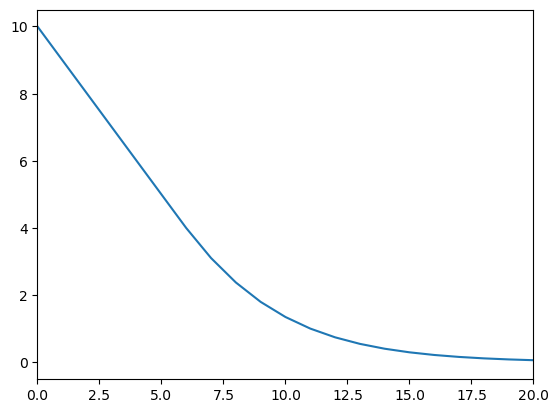

In [15]:
S,vNew = crankNicolson_AmerPut(10,1,0.05 , 0.4,50,50,50,1.e8,1.e-8,50)

# check a plot to see what it looks like
plt.xlim(0,20)
plt.plot(S,vNew)

Here we see that the method only takes one or two iterations to converge, and the plot looks very similar to before.

# Tasks

- Using interpolation to calculate the value at $S_0=X$ and with $S^U=50$, and different values of $imax$ and $jmax$, verify the convergence rate of this algorithm is $O((\Delta t)^2,(\Delta S)^2)$.
- Try using Richardson extrapolation to improve your calculated results.
- Using interpolation to calculate the value at $S_0=9.735$, is the convergence rate still $O((\Delta t)^2,(\Delta S)^2)$?
- What is the efficincy of this method compared to the previous one? Say we want 6 digits of accuracy for the option value, which method can calculate it quicker? Can you use `numba` to compile and speed up your code where possible?
- Update this code to include dividends, and make it solve for a call option. 
